In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp
import os

tf.keras.mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6
2.6.3


In [2]:
train = pd.read_parquet('E:/train_low_mem.parquet')

In [3]:
def make_train_dataset(x, y, batch_size=2048, mode='train'):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if mode=='train':
        ds = ds.shuffle(8192)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
def preprocessing_mean_time(df):
    feats = df.loc[:, 'target':'f_299']
    return feats.mean()
inv = list(train['time_id'].unique())
n = int(len(inv))
split = int(n*0.8)
means = train.groupby('time_id').apply(preprocessing_mean_time)
mean_train_subset, mean_valid_subset = means.iloc[:split, :], means.iloc[split:, :]
means_x, means_y = mean_train_subset.loc[:,'f_0':'f_299'], mean_train_subset['target']
val_means_x, val_means_y = mean_valid_subset.loc[:,'f_0':'f_299'], mean_valid_subset['target']
m_train, m_valid = make_train_dataset(means_x, means_y), make_train_dataset(val_means_x, val_means_y, mode='valid')

In [5]:
def preprocessing_train_time(df):
    feats = df.loc[:, 'target':'f_299']
    feats -= feats.mean()
    return pd.concat([df[['time_id', 'investment_id']], feats], axis=1)
train = train.groupby('time_id', as_index=False).apply(preprocessing_train_time)
#train = train.reset_index()

In [12]:
train_id, val_id = inv[:split], inv[split:]
train_subset = train.loc[train['time_id'].isin(train_id)]
valid_subset = train.loc[train['time_id'].isin(val_id)]
x, y = train_subset.loc[:,'f_0':'f_299'], train_subset['target']
val_x, val_y = valid_subset.loc[:,'f_0':'f_299'], valid_subset['target']
train, valid = make_train_dataset(x, y), make_train_dataset(val_x, val_y, mode='valid')

AttributeError: 'PrefetchDataset' object has no attribute 'loc'

In [21]:
import gc
del train
del train_id
del val_id
del train_subset
gc.collect()

938

In [7]:
def pearson_corr(y_true, y_pred, axis=-1):
    return tfp.stats.correlation(tf.squeeze(y_pred), tf.squeeze(y_true), sample_axis=axis, event_axis=None)

def pearson_corr_loss(y_true, y_pred, axis=-1):
    return 1 - pearson_corr(y_true, y_pred, axis=axis)

In [8]:
def make_means_model():
    mIn = keras.Input(shape=(300,))
    m = Dense(128)(mIn)
    m = Dropout(0.5)(m)
    mOut = Dense(1)(m)
    means_model = Model(inputs=mIn, outputs=mOut)
    return means_model

def make_alpha_model():
    xIn = keras.Input(shape=(300,))
    x = Dense(256, activation="swish")(xIn)
    x = Dropout(0.2)(x)
    x = Dense(256, activation="swish")(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation="swish")(x)
    x = Dropout(0.2)(x)
    x = Concatenate(axis=-1)([x, xIn])
    x = Dense(256, activation="swish")(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation="swish")(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="swish")(x)
    xOut = Dense(1)(x)
    alpha_model = Model(inputs=xIn, outputs=xOut)
    return alpha_model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               38528     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 38,657
Trainable params: 38,657
Non-trainable params: 0
_________________________________________________________________


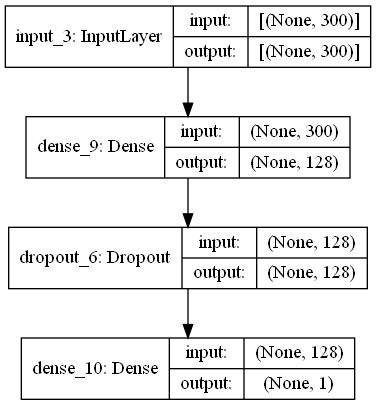

In [21]:
means_model = make_means_model()
means_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["mse"])
means_model.summary()
plot_model(means_model, to_file='means_model.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          77056       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dropout[0][0]                    
______________________________________________________________________________________________

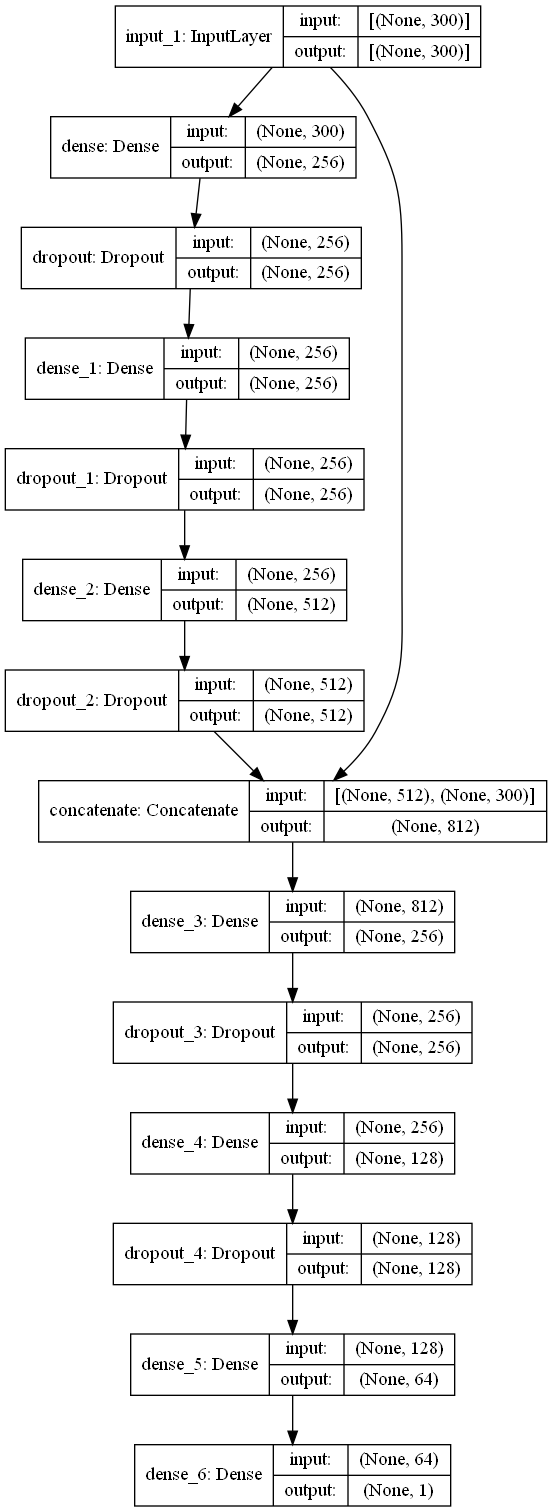

In [9]:
alpha_model = make_alpha_model()
alpha_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["mse"])
alpha_model.summary()
plot_model(alpha_model, to_file='means_model.png', show_shapes=True)

In [22]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=20, verbose=1, monitor='val_mse', mode='min'),
             tf.keras.callbacks.TerminateOnNaN()]
means_model.fit(m_train, epochs=2000, valiDDdation_data=m_valid, use_multiprocessing=True, verbose=1)

Epoch 1/2000
1/1 [==============================] - 1s 723ms/step - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0319 - val_mse: 0.0318
Epoch 2/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 3/2000
1/1 [==============================] - 0s 22ms/step - loss: 0.0767 - mse: 0.0767 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 4/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.0723 - mse: 0.0723 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 5/2000
1/1 [==============================] - 0s 22ms/step - loss: 0.0727 - mse: 0.0727 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 6/2000
1/1 [==============================] - 0s 23ms/step - loss: 0.0633 - mse: 0.0633 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 7/2000
1/1 [==============================] - 0s 22ms/step - loss: 0.0681 - mse: 0.0681 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 8/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.0651 - 

In [19]:
means_model.save('means_model')
# !zip -r means_model.zip ./means_model

INFO:tensorflow:Assets written to: means_model\assets


In [14]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(f"alpha_model", monitor='val_mse', save_best_only=True, mode='min'),
                 tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1, monitor='val_mse', mode='min'),
                 tf.keras.callbacks.TerminateOnNaN()]

alpha_model.fit(train, epochs=50, validation_data=valid, callbacks=callbacks, use_multiprocessing=True, verbose=1)

Epoch 1/50
1153/1153 [==============================] - 12s 6ms/step - loss: 0.8435 - mse: 0.8435 - val_loss: 0.8103 - val_mse: 0.8103
INFO:tensorflow:Assets written to: alpha_model\assets
Epoch 2/50
1153/1153 [==============================] - 8s 7ms/step - loss: 0.8341 - mse: 0.8341 - val_loss: 0.8088 - val_mse: 0.8088
INFO:tensorflow:Assets written to: alpha_model\assets
Epoch 3/50
1153/1153 [==============================] - 5s 4ms/step - loss: 0.8314 - mse: 0.8314 - val_loss: 0.8077 - val_mse: 0.8077
INFO:tensorflow:Assets written to: alpha_model\assets
Epoch 4/50
1153/1153 [==============================] - 5s 5ms/step - loss: 0.8296 - mse: 0.8296 - val_loss: 0.8076 - val_mse: 0.8076
INFO:tensorflow:Assets written to: alpha_model\assets
Epoch 5/50
1153/1153 [==============================] - 5s 4ms/step - loss: 0.8284 - mse: 0.8284 - val_loss: 0.8073 - val_mse: 0.8073
INFO:tensorflow:Assets written to: alpha_model\assets
Epoch 6/50
1153/1153 [==============================] - 5s 

Epoch 1/50
1153/1153 [==============================] - 5s 5ms/step - loss: 0.8265 - mse: 0.8265 - val_loss: 0.8072 - val_mse: 0.8072
INFO:tensorflow:Assets written to: alpha_model\assets
Epoch 2/50
1153/1153 [==============================] - 5s 5ms/step - loss: 0.8255 - mse: 0.8255 - val_loss: 0.8077 - val_mse: 0.8077
Epoch 3/50
1153/1153 [==============================] - 5s 4ms/step - loss: 0.8250 - mse: 0.8249 - val_loss: 0.8081 - val_mse: 0.8081
Epoch 4/50
1153/1153 [==============================] - 5s 4ms/step - loss: 0.8245 - mse: 0.8245 - val_loss: 0.8084 - val_mse: 0.8084
Epoch 5/50
1153/1153 [==============================] - 5s 4ms/step - loss: 0.8241 - mse: 0.8241 - val_loss: 0.8087 - val_mse: 0.8087
Epoch 6/50
1153/1153 [==============================] - 5s 4ms/step - loss: 0.8238 - mse: 0.8238 - val_loss: 0.8089 - val_mse: 0.8089
Epoch 7/50
1153/1153 [==============================] - 5s 4ms/step - loss: 0.8236 - mse: 0.8236 - val_loss: 0.8090 - val_mse: 0.8090

Epoch 0

In [15]:
alpha_model.save('alpha_model')

INFO:tensorflow:Assets written to: alpha_model\assets
